In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from itertools import dropwhile
from scipy.stats import t
from datetime import datetime
from tqdm import tqdm
import re

# local imports
from helpers.sql import connect_to_db, update_database, read_db
from helpers.ar_model import transform, transformation, forecast_residual
from helpers.fama_macbeth import FamaMacbeth

plt.style.use('ggplot')

# Unexpected climate change
This script generates the measure of unexpected climate change perception using AR(1) model


In [3]:
# Connect to database (downloads if not exist)
engine = connect_to_db()

# Set this to True to update database locally
update = False

if update:
    update_database()


In [4]:
sentiment_sum_ar1 = read_db(
    engine=engine, statement="select * from climate_sum_ar1", idx_col="date"
)
sentiment_mean_n_ar1 = read_db(
    engine=engine, statement="select * from climate_mean_n_ar1", idx_col="date"
)


In [5]:
names = {
    "aggregate_transformed": "Aggregate",
    "politics_transformed": "Politics",
    "weather_extremes_transformed": "Weather Extremes",
    "importance_of_human_intervantion_transformed": "Imp. of Human Intervention",
}

Sum measure


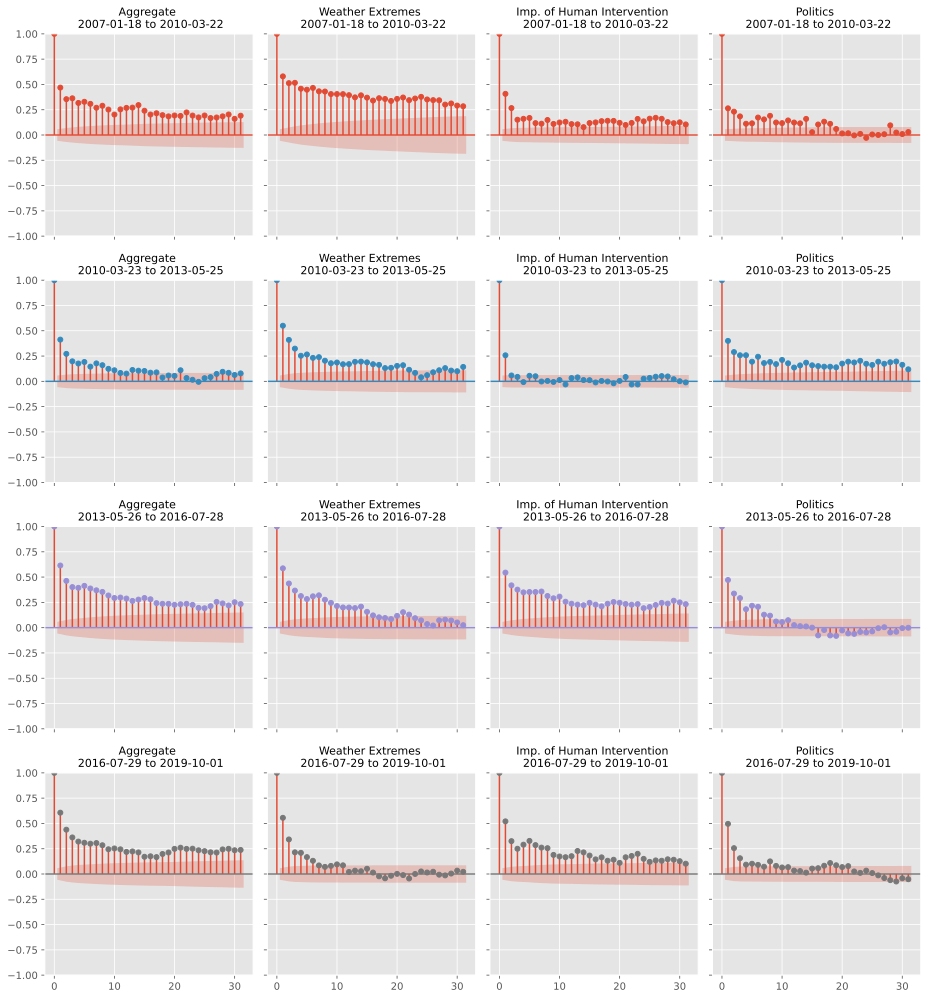

Mean_n measure


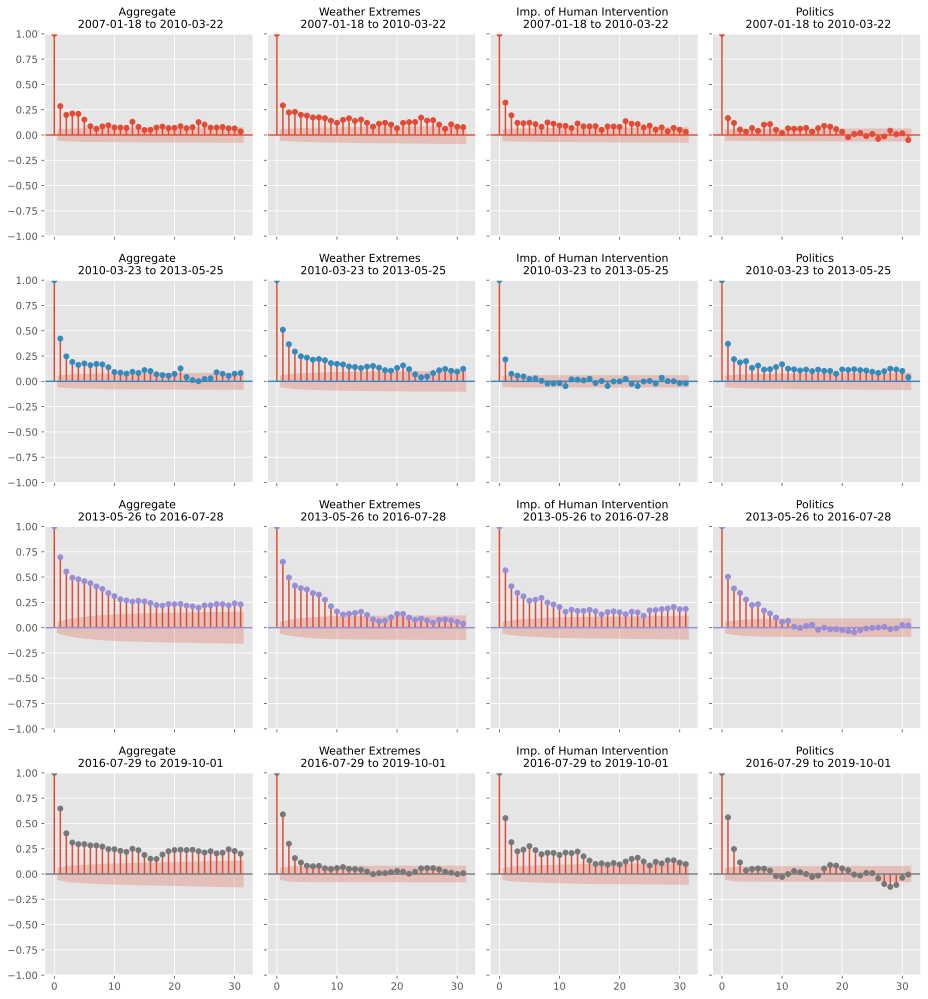

In [6]:
def plot_acfs(transformed, save: bool):
    fig, axes = plt.subplots(4, 4, figsize=(13, 14), sharex=True, sharey=True)

    transformed = transformed.dropna(how="any")
    transformed = transformed.iloc[2:]

    splits = np.split(transformed.index, 4)

    plot_data = [{"color": "C0"}, {"color": "C1"}, {"color": "C2"}, {"color": "C3"}]

    for j, split in enumerate(splits):
        for i, col in enumerate(transformed.columns):
            min_date_sting = datetime.strftime(split.min(), "%Y-%m-%d")
            max_date_sting = datetime.strftime(split.max(), "%Y-%m-%d")

            plot_acf(
                transformed[col].loc[split],
                ax=axes[j, i % 4],
                color=plot_data[j].get("color"),
            )
            axes[j, i % 4].set_title(
                f"{names.get(col)} \n {min_date_sting} to {max_date_sting}",
                fontdict={"fontsize": 11},
            )

    # adjust spacing
    plt.tight_layout()

    if save:
        fig.savefig(f"plots/acf_functions.png", dpi=450, bbox_inches="tight")

    plt.show()


print("Sum measure")
plot_acfs(
    sentiment_sum_ar1.filter(
        regex="(aggregate|politics|extremes|intervantion)_transformed$"
    ).copy(),
    save=True,
)
print("Mean_n measure")
plot_acfs(
    sentiment_mean_n_ar1.filter(
        regex="(aggregate|politics|extremes|intervantion)_transformed$"
    ).copy(),
    save=False,
)


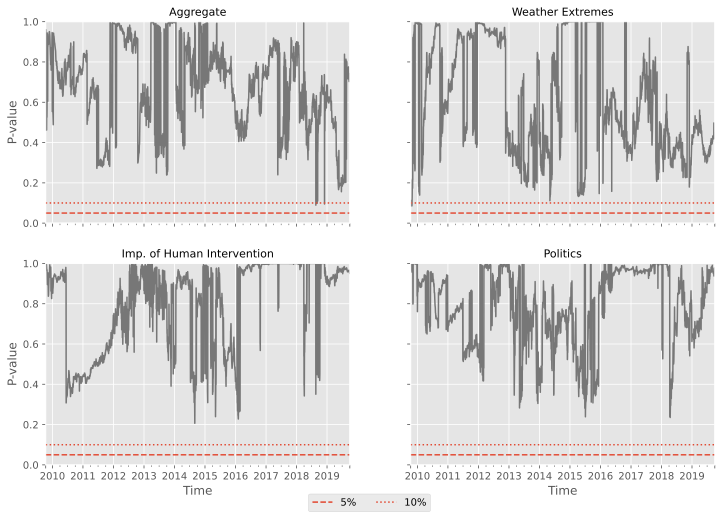

In [7]:
pvalues = sentiment_sum_ar1.filter(
    regex="(aggregate|politics|extremes|intervantion).+_f_pval$"
)


fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
pvalues = pvalues.dropna(how="any")

for i, col in enumerate(pvalues.columns):

    pvalues[col].plot(
        ax=axes[i // 2, i % 2], color="C3", label="P-value for joint AR test"
    ),

    axes[i // 2, i % 2].set_title(
        f'{names.get(col.replace("_f_pval", ""))}',
        fontdict={"fontsize": 11},
    )

    axes[i // 2, i % 2].axhline(0.05, linestyle="--", label="5%", color="C0")
    axes[i // 2, i % 2].axhline(0.1, linestyle=":", label="10%", color="C0")
    axes[i // 2, i % 2].set_ylim(0, 1)
    axes[i // 2, i % 2].set_ylabel("P-value")
    axes[i // 2, i % 2].set_xlabel("Time")


# add legend
plt.figlegend(
    loc="lower center",
    ncol=3,
    labelspacing=1,
    bbox_to_anchor=(0.5, 0.02),
    handles=axes[0, 0].get_legend_handles_labels()[0][1:],
)


fig.savefig(f"plots/p_values_f_test.png", dpi=450, bbox_inches="tight")

plt.show()


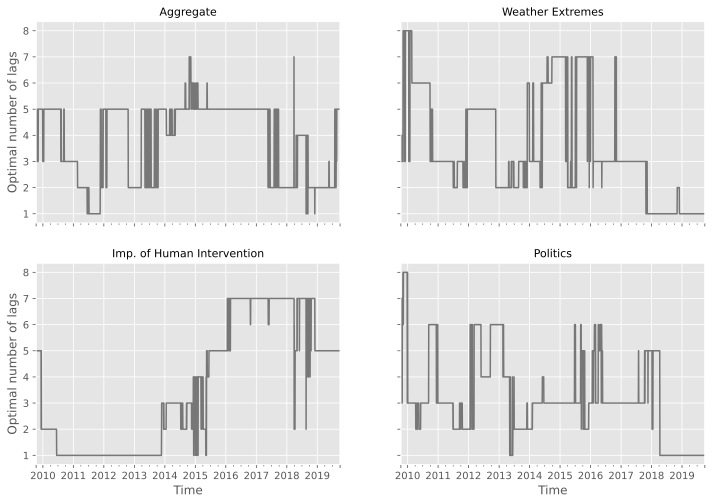

In [8]:
pvalues = sentiment_sum_ar1.filter(
    regex="(aggregate|politics|extremes|intervantion).+_lags$"
)


fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
pvalues = pvalues.dropna(how="any")

for i, col in enumerate(pvalues.columns):

    pvalues[col].plot(
        ax=axes[i // 2, i % 2], color="C3", label="Optimal number of lags"
    ),

    axes[i // 2, i % 2].set_title(
        f'{names.get(col.replace("_lags", ""))}',
        fontdict={"fontsize": 11},
    )

    axes[i // 2, i % 2].set_ylabel("Optimal number of lags")
    axes[i // 2, i % 2].set_xlabel("Time")


# add legend
# plt.figlegend(
#     loc="lower center",
#     ncol=3,
#     labelspacing=1,
#     bbox_to_anchor=(0.5, 0.02),
#     handles=axes[0, 0].get_legend_handles_labels()[0],
# )

fig.savefig(f"plots/optimal_lags.png", dpi=450, bbox_inches="tight")

plt.show()
